In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

In [3]:
# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [4]:
# Import all of them 
sales=pd.read_csv('sales_train_v2.csv', sep=',', encoding='utf8')

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv('item_categories.csv', sep=',', encoding='utf8')
item=pd.read_csv('items.csv', sep=',', encoding='utf8')
sub=pd.read_csv('sample_submission.csv', sep=',', encoding='utf8')
shops=pd.read_csv('shops.csv', sep=',', encoding='utf8')
test=pd.read_csv('test.csv', sep=',', encoding='utf8')

In [5]:
#Отформатируем дату корректно
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
# check
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [6]:
# Объединим метрики по значению месяца (порядковый номер)

monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

## Lets break down the line of code here:
# aggregate by date-block(month),shop_id and item_id
# select the columns date,item_price and item_cnt(sales)
# Provide a dictionary which says what aggregation to perform on which column
# min and max on the date
# average of the item_price
# sum of the sales

In [7]:
# take a peak
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

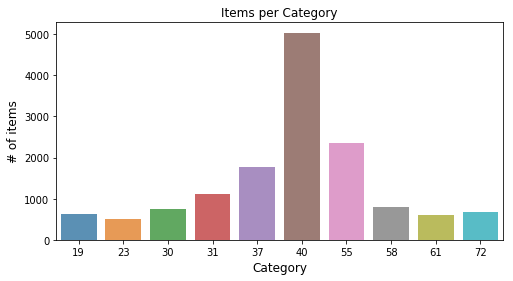

In [8]:
# Количество элементов в категории

x=item.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

# Получаем график распределения эл-тов по категориям. Видим что он неравномерный

Of course, there is a lot more that we can explore in this dataset, but let's dive into the time-series part.

Single series:
The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

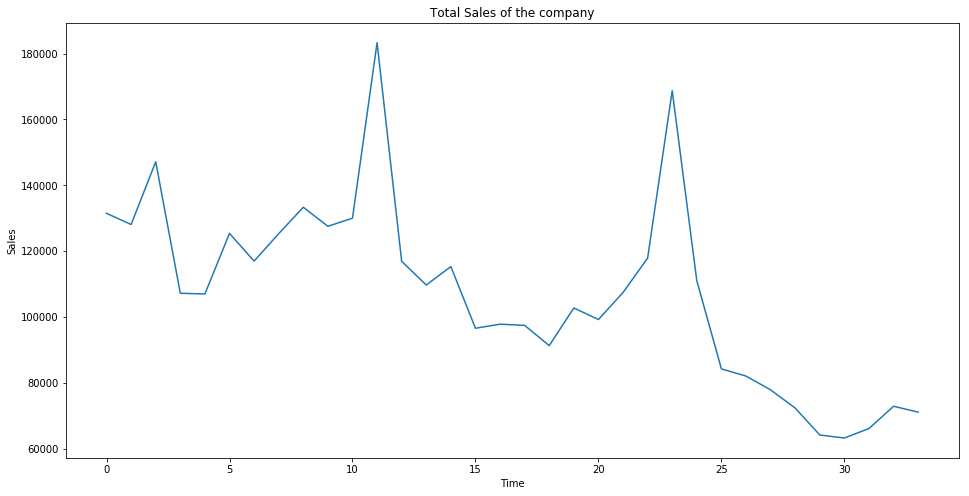

In [9]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

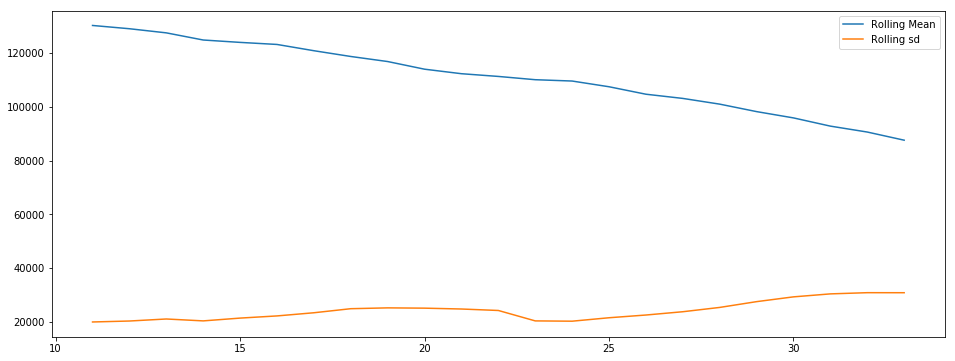

In [10]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

Есть очевидная «сезонность» (например, пиковые продажи в какое-то время года) и понижающийся «тренд».

Проверим это с помощью быстрого разложения на тренд, сезонность и остатки.

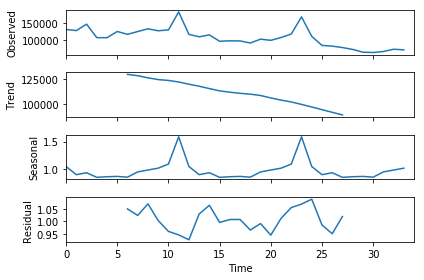

In [11]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

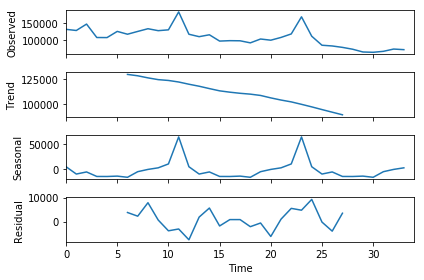

In [12]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()


мы предполагаем аддитивную модель, тогда мы можем написать

уг = ST + Тт + Et

где yt - данные в период t, St - сезонный компонент в период t, Tt - компонент цикла тренда в период t, а Tt - компонент остатка (или нерегулярный или ошибочный) в период t Аналогично для мультипликативной модели,

yt = St x Tt x Et

Стационарность относится к неизменности времени ряда. (т.е.) две точки во временном ряду связаны друг с другом только тем, насколько они далеко друг от друга, а не направлением (вперед / назад)

Когда временной ряд является стационарным, его легче моделировать. Методы статистического моделирования предполагают или требуют, чтобы временные ряды были стационарными.

Существует несколько тестов, которые можно использовать для проверки стационарности.

ADF( Augmented Dicky Fuller Test)
KPSS
PP (Phillips-Perron test)

Давайте просто выполним ADF, который является наиболее часто используемым.

In [13]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [14]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

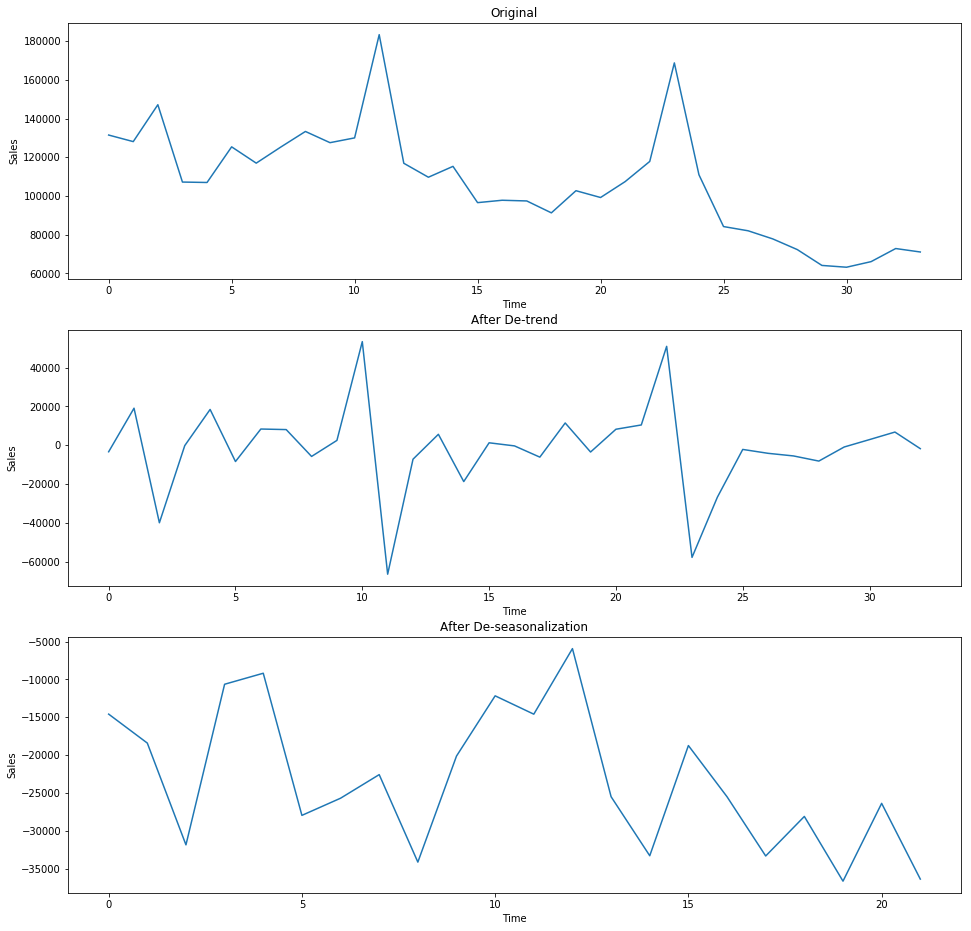

In [15]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [16]:
# Теперь снова проверяем стационарность после де-сезонности
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


Теперь после преобразований наше p-значение для теста DF находится в пределах 5%. Следовательно, мы можем предположить стационарность ряда
Мы можем легко вернуть исходный ряд, используя функцию обратного преобразования, которую мы определили выше.

Теперь давайте погрузимся в составление прогнозов!

Модели AR, MA и ARMA:
TL: DR версия моделей:

MA - Следующее значение в серии является функцией среднего от предыдущего n числа значений AR - Ошибки (разница в среднем) следующего значения - это функция ошибок предыдущего n числа значений ARMA - смесь обоих.

Теперь, как мы узнаем, находится ли наш временной ряд в процессе AR или процессе MA?

Давайте разберемся!

In [17]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 


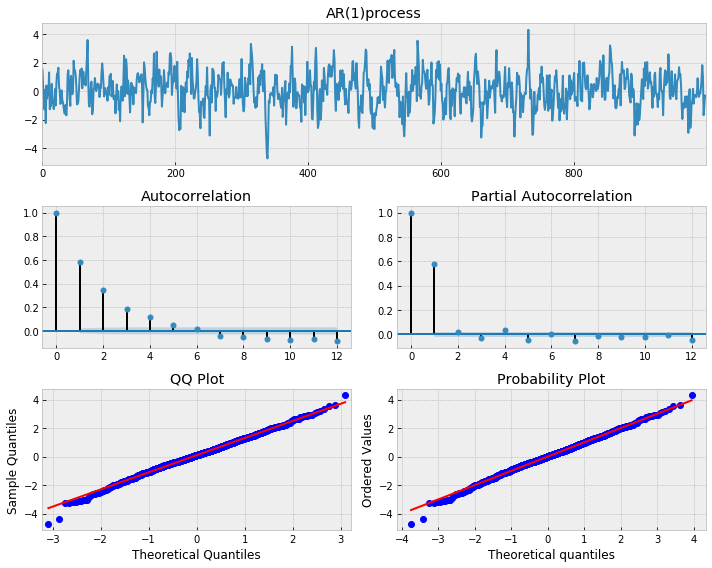

In [18]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

# AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

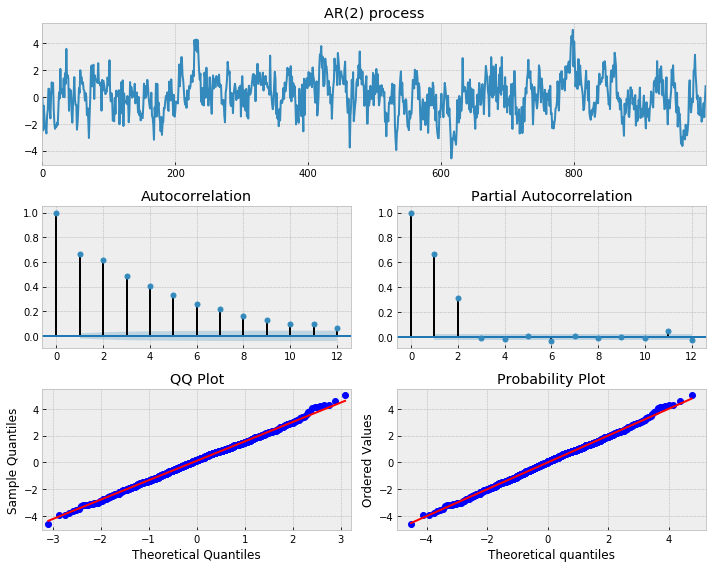

In [19]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python требует, чтобы мы указали значение нулевой задержки, равное 1
# Также обратите внимание, что альфа для модели AR должны быть сведены на нет
# Мы также устанавливаем бета для MA равные 0 для модели AR (p)
# Для получения дополнительной информации см. примеры на statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

# MA(1) process -- has ACF cut off at lag=1

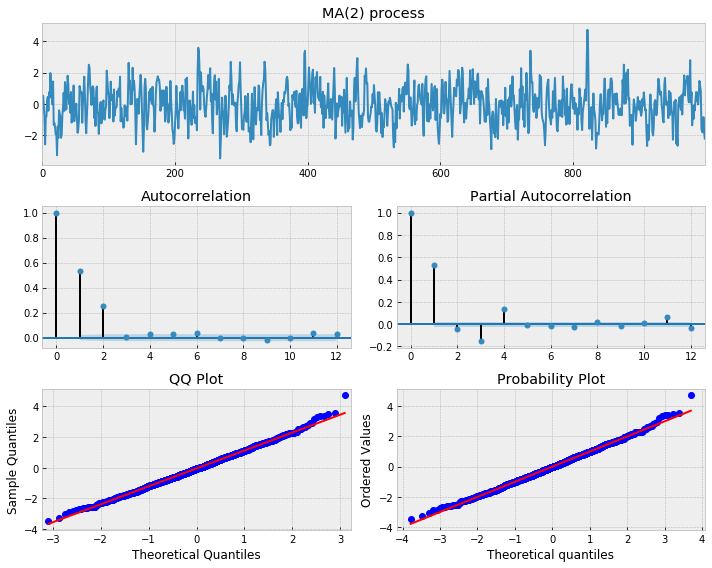

In [20]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

# MA(2) process -- has ACF cut off at lag=2

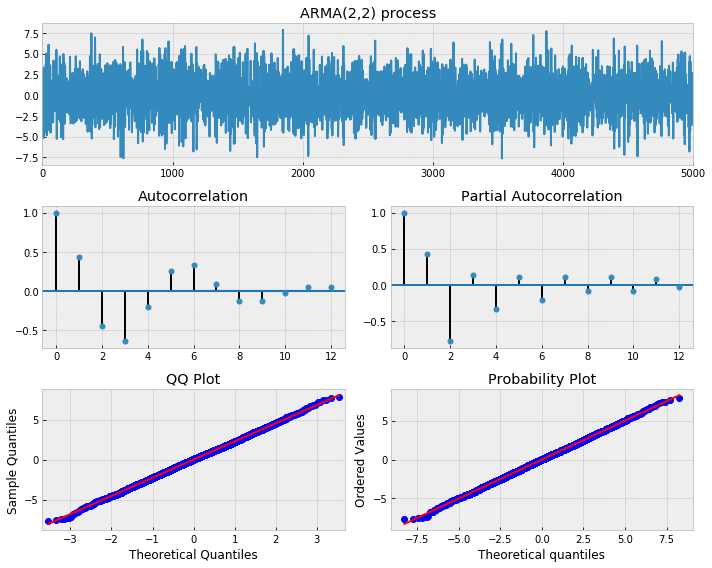

In [21]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

Now things get a little hazy. Its not very clear/straight-forward.
A nifty summary of the above plots:

ACF Shape	Indicated Model
Exponential, decaying to zero	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model
Alternating positive and negative, decaying to zero Autoregressive model.	Use the partial autocorrelation plot to help identify the order.
One or more spikes, rest are essentially zero	Moving average model, order identified by where plot becomes zero.
Decay, starting after a few lags	Mixed autoregressive and moving average (ARMA) model.	
All zero or close to zero	Data are essentially random.	
High values at fixed intervals	Include seasonal autoregressive term.	
No decay to zero	Series is not stationary

# Давайте использовать системный подход для определения порядка процессов AR и MA.

In [27]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15377.27398 | order: (4, 4)


We've correctly identified the order of the simulated process as ARMA(2,2).
Lets use it for the sales time-series.

In [24]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [25]:
# Просто используем best_mdl.predict (), чтобы предсказать следующие значения

In [26]:
# добавим даты во временной ряд в качестве индекса
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


## Prophet:


Недавно открыт с помощью исследования Facebook. 
Это очень многообещающий инструмент,
который часто является очень удобным и быстрым решением 
для разочаровывающей плоской линии

Конечно, можно утверждать, что при правильной предварительной обработке и тщательной настройке параметров приведенный выше график не произойдет.

Но правда в том, что у большинства из нас нет ни терпения, ни опыта, чтобы это произошло.

Кроме того, есть факт, что в большинстве практических сценариев часто бывает много временных рядов, которые необходимо прогнозировать. Например: это соревнование. Это требует, чтобы мы прогнозировали продажи в следующем месяце для комбинаций уровня Магазина, которые могли быть в тысячах (то есть) предсказывали тысячи параметров

Еще одна полезная функциональность заключается в том, что он соответствует типичному синтаксису sklearn.

По своей сути процедура Prophet представляет собой модель аддитивной регрессии с четырьмя основными компонентами:

Кусочно-линейный или логистический тренд кривой роста. Prophet автоматически обнаруживает изменения в тенденциях, выбирая точки изменения из данных.
Ежегодный сезонный компонент моделируется с использованием рядов Фурье.
Еженедельный сезонный компонент с использованием фиктивных переменных.
Предоставленный пользователем список важных праздников.

Resources for learning more about prophet:

https://www.youtube.com/watch?v=95-HMzxsghY
https://facebook.github.io/prophet/docs/quick_start.html#python-api
https://research.fb.com/prophet-forecasting-at-scale/
https://blog.exploratory.io/is-prophet-better-than-arima-for-forecasting-time-series-fa9ae08a5851

In [28]:
from fbprophet import Prophet
#prophet требует pandas df в приведенном ниже конфиге
# (столбец даты с именем DS и столбец значения с Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) # Создаём Prophet только с ежегодной сезонностью, поскольку наши данные ежемесячны 
model.fit(ts) #обучим модель на датафрейме

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
# прогнозируем на пять месяцев в будущем, а MS - месяц начала частоты
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# теперь сделаем прогнозы
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,81971.573253,78870.142015,85025.150120
35,2015-12-01,127820.003004,124826.357487,130805.374798
36,2016-01-01,76457.834940,73237.594399,79599.224070
37,2016-02-01,41079.214344,37713.789005,44109.958120
38,2016-03-01,77765.462679,74719.590928,80790.397171


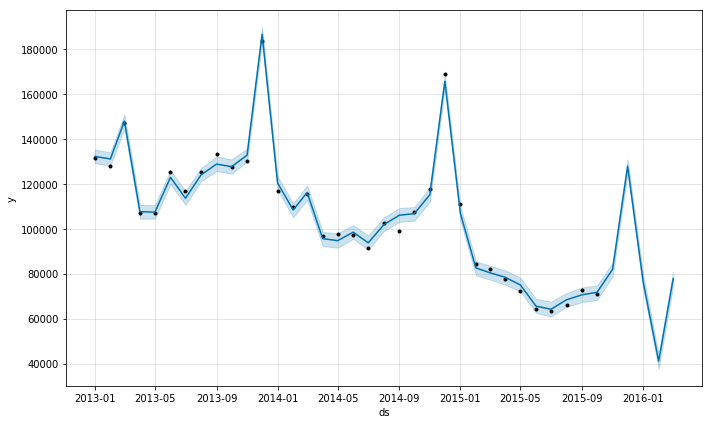

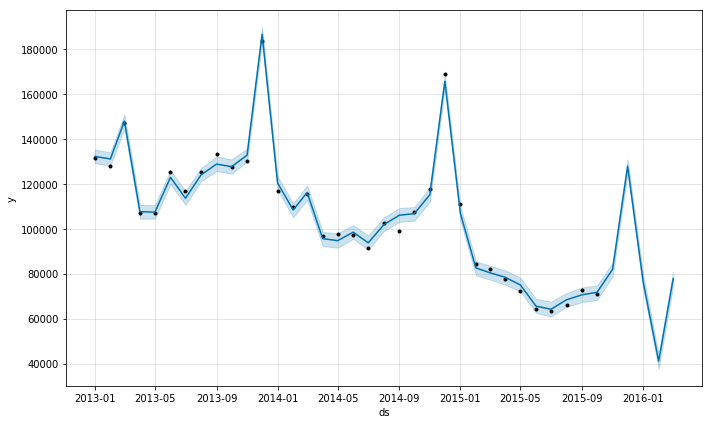

In [30]:
model.plot(forecast)

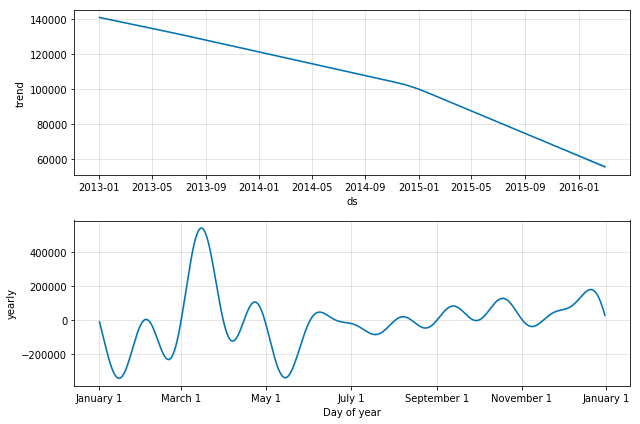

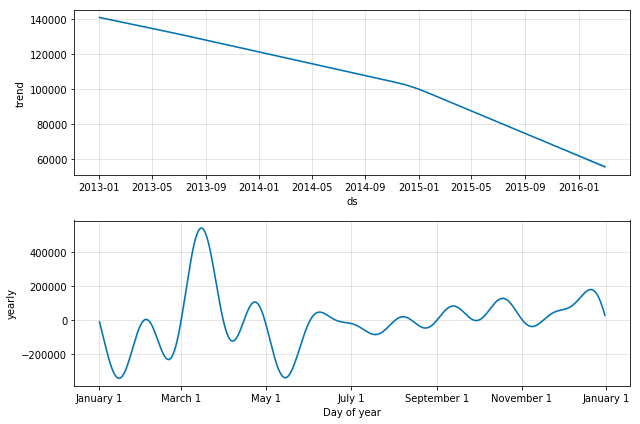

In [31]:
model.plot_components(forecast)

! Тенденция и сезонность от Prophet выглядят подобными тем, которые мы имели ранее, используя традиционные методы.

# Hierarchical time series:

Иерархический временной ряд:
Прогнозирование: принципы и практика, является окончательным справочником по прогнозированию Робом Дж. Хиндманом.

Он излагает основы работы с групповыми или иерархическими прогнозами. Рассмотрим следующий простой сценарий.

Хиндман предлагает следующие методы для оценки точек в этой иерархии. Я попытался упростить язык, чтобы сделать его более интуитивным.

Подход «снизу вверх:
Прогнозируйте все ряды базового уровня, используя любой метод, а затем просто агрегируйте его на вершину.
Преимущества: просто, информация не теряется из-за агрегации.
Недостатки: низкие уровни могут быть шумными
Нисходящий подход:
Спрогнозировать верхний уровень первым. (Например: сначала спрогнозировать общий объем продаж)
Затем вычислите веса, которые обозначают долю общих продаж, которая должна быть дана прогнозу базового уровня (например, вклад продаж товара в общие продажи).
Существуют разные способы достижения «весов».
Средние исторические пропорции - простое среднее значение вклада товара в продажи за последние месяцы
Доля средних значений за прошлый период. Вес - это отношение среднего значения нижнего ряда к среднему значению общего ряда (например, вес (элемент1) = среднее (элемент1) / среднее (всего_продаж))
Прогнозируемые пропорции - прогнозирование доли в будущем с использованием изменений в прошлых пропорциях.
Используйте эти веса для расчета базовых прогнозов и других уровней
Посередине:
Используйте как снизу вверх, так и сверху вниз вместе.
Например: рассмотрим нашу проблему прогнозирования прогнозов на уровне магазина.
Возьмите средний уровень (Магазины) и найдите прогнозы для магазинов
Используйте подход снизу вверх, чтобы найти общие продажи
Отключите продажи в магазине, используя пропорции, чтобы найти продажи на уровне товаров, используя подход «сверху вниз».
Оптимальный комбинированный подход:
Прогноз для всех слоев независимо
Поскольку все уровни независимы, они могут не соответствовать иерархии
Например: поскольку товары прогнозируются независимо, сумма товаров, проданных в магазине, может не совпадать с прогнозируемой продажей магазина или, как говорит Хиндман, «совокупная согласованность»
Затем происходят некоторые матричные вычисления и корректировки, чтобы обеспечить специальные корректировки прогноза, чтобы привести их в соответствие с иерархией.
Хватит теории. Давайте начнем делать прогнозы! :П
Задача здесь под рукой, имеет 22170 наименований и 60 магазинов. Это указывает на то, что мы можем предсказать около миллиона отдельных временных рядов (комбинаций предметов и магазинов)!

Настройка каждого из них была бы почти невозможна. Давайте использовать Prophet, который делает это для нас.

Начиная с подхода снизу вверх.

Здесь есть еще несколько моментов, которые следует учитывать:

-Не все магазины продают все товары
-Что происходит, когда вводится новый продукт?
-Что делать, если продукт снят с полок?

In [32]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [33]:
# получим уникальные комбинации item-store из данных продаж на ежемесячном уровне
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# организовать это удобно для выполнения hts
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()



shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [34]:
import time
start_time=time.time()

In [35]:
# Снизу вверх
# Рассчитаем базу прогнозов используя Prophet

In [36]:
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
# print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break

ValueError: Dataframe must have columns 'ds' and 'y' with the dates and values respectively.

# Middle out:

In [ ]:
# Прогноз для уровня магазина

In [37]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [38]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [39]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
       predictions = np.concatenate((predictions, f2), axis = 1)

In [40]:
predictions_unknown=predictions[-1]
predictions_unknown

array([-795.74290684, -465.86418046, 1113.70597072,  851.51134783,
        984.39826266, 1412.37347363, 2251.12571885, 1740.25032709,
       -330.52613852,   40.09415824,  564.0713723 ,   21.91173373,
       4406.40539688, -333.4880942 , 1300.06227948, 1763.08618811,
       1007.06618609,  921.30082113,  847.41144183, 1800.29004637,
       -681.46089582, 2147.18708478, 1412.5071537 , -655.26354747,
       1677.25200566, 6716.38740684, 1367.67815225, 3442.74789278,
       4218.75211786,  738.85091433,  395.88793447, 8011.87371936,
       -713.1520182 ,  575.52016274])

# Submission must have 214200 rows